# Fink case study: extragalactic science

<img src="../Fink_PrimaryLogo_WEB.jpg" width=300 />

## Goal

The goal of this notebook is to show how Fink can contribute to extragalactic science. This notebook includes queries for Active Galactic Nucleii and Supernova science. 

## What is behind?

This notebook will use:
- Fink cross-match with close by sources using CDS xmatch service.
- Fink's machine learning classification scores [SuperNNova](https://github.com/supernnova/SuperNNova) [(Möller & de Boissière 2019)](https://academic.oup.com/mnras/article-abstract/491/3/4277/5651173)  and Random Forest [(Ishida et al. 2019b)](https://ui.adsabs.harvard.edu/abs/2019MNRAS.483....2I/abstract)
- Fink's processing of extra features such as color "r-g" when possible.

# 1st case study: known AGNs

### API query: latest alerts associated with known AGNs
Query latest n=5 alerts spatially coincident with a catalogued AGN in the CDS Simbad catalogue

In [1]:
import requests
import pandas as pd

# Get latests 100 alerts linked to AGNs
r = requests.post(
  'http://134.158.75.151:24000/api/v1/latests',
  json={
    'class': 'AGN', # tag from CDSxmatch service
    'n': '5' # number of alerts
  }
)

# Format output in a DataFrame
pdf = pd.read_json(r.content)

This table contains all alerts linked to a CDS catalogue AGN. This includes
- Alert information from ZTF processing (just latest photometry points).
- Fink's added values.

In [2]:
pdf

,d:cdsxmatch,d:knscore,d:mulens_class_1,d:mulens_class_2,d:rfscore,d:roid,d:snn_sn_vs_all,d:snn_snia_vs_nonia,i:candid,i:chipsf,...,i:ssdistnr,i:ssmagnr,i:ssnamenr,i:tooflag,i:xpos,i:ypos,v:classification,v:r-g,v:rate(r-g),v:lastdate
0,AGN,0,,,0.072,0,0.857717,0.852220,1549473362815010004,2.041177,...,-999,-999,null,0,1372.0693,222.2328,AGN,NaN,NaN,2021-03-30 11:21:39.004
1,AGN,0,,,0.074,0,0.564303,0.887685,1549446933315010001,14.041026,...,-999,-999,null,0,3051.3018,833.6582,AGN,0.077047,NaN,2021-03-30 10:43:35.003
2,AGN,0,VARIABLE,,0.306,0,0.146580,0.895728,1549446460315015000,3.692214,...,-999,-999,null,0,553.9576,107.2556,AGN,NaN,NaN,2021-03-30 10:42:54.999
3,AGN,0,,,0.062,0,0.680073,0.805657,1549412003315010002,2.102315,...,-999,-999,null,0,3055.1880,827.1186,AGN,0.077047,NaN,2021-03-30 09:53:16.999
4,AGN,0,,,0.154,0,0.002409,0.717150,1549408566315010003,1.970873,...,-999,-999,null,0,670.2656,589.1633,AGN,NaN,NaN,2021-03-30 09:48:19.999


Get objects Ids associated to these latest 100 alerts associated to AGNs in ZTF.

In [3]:
recent_AGN_objectIds = pdf['i:objectId'].unique()

### API query: get photometry for one of these AGNs

In [4]:
# import requests
# import pandas as pd
r = requests.post(
  'http://134.158.75.151:24000/api/v1/objects',
  json={
    'objectId': recent_AGN_objectIds[0],
    'output-format': 'json'
  }
)

# Format output in a DataFrame
single_object = pd.read_json(r.content)

### Analysing the output: plot the light-curve for visualization

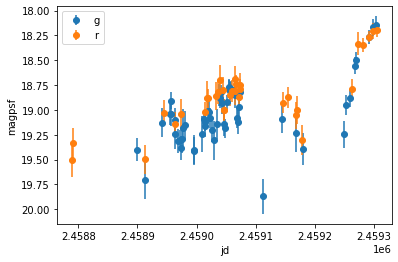

In [6]:
import matplotlib.pyplot as plt
dic_flt = {1:"g", 2:"r", 3:"i"}
filter_color = {1: '#1f77b4', 2: '#ff7f0e', 3: '#2ca02c'}
for flt in [1,2]:
    df_byflt = single_object[single_object['i:fid']==flt]
    plt.errorbar(df_byflt['i:jd'], df_byflt['i:magpsf'], yerr=df_byflt['i:sigmapsf'],fmt='o',label=dic_flt[flt])
plt.xlabel('jd')
plt.ylabel('magpsf')
plt.legend()
plt.gca().invert_yaxis()
plt.show()

# 2nd case study: early supernovae candidates
Early supernova candidates is a tag defined and provided by Fink. It requires that the alert has no known transient association (from catalogues), it is relatively new (number of previous detections < 10) and when both a [SuperNNova](https://github.com/supernnova/SuperNNova) [(Möller & de Boissière 2019)](https://academic.oup.com/mnras/article-abstract/491/3/4277/5651173) trained to identify SNe Ia or SNe and a Random Forest (Leoni et al. in prep.) based on [(Ishida et al. 2019b)](https://ui.adsabs.harvard.edu/abs/2019MNRAS.483....2I/abstract) trained to select early supernovae have a probability higher than 50% of this object being a SN.

### API query: latest alerts tagged as early supernovae candidates

In [7]:
# Get latests 5 Early SN candidates
r = requests.post(
  'http://134.158.75.151:24000/api/v1/latests',
  json={
    'class': 'Early SN candidate',
    'n': '50'
  }
)

# Format output in a DataFrame
pdf = pd.read_json(r.content)

### Analysing the output: color of these alerts (if g and r measurements in the same night)
This color is an added value by Fink if there is photmetry in a single night for two filters

In [10]:
candSNe_w_color = pdf[(~pdf["v:r-g"].isna())]
candSNe_w_color[candSNe_w_color.columns[::-1]]

,v:lastdate,v:rate(r-g),v:r-g,v:classification,i:ypos,i:xpos,i:tooflag,i:ssnamenr,i:ssmagnr,i:ssdistnr,...,i:chipsf,i:candid,d:snn_snia_vs_nonia,d:snn_sn_vs_all,d:roid,d:rfscore,d:mulens_class_2,d:mulens_class_1,d:knscore,d:cdsxmatch
1,2021-03-30 10:52:01.998,NaN,0.121711,Early SN candidate,1930.4219,464.3215,0,null,-999,-999,...,12.254282,1549452800415015005,0.858388,0.766572,0,0.865,,,0.00,Unknown
2,2021-03-30 08:57:45.000,NaN,0.121711,Early SN candidate,1911.2162,458.2910,0,null,-999,-999,...,4.316452,1549373430415015003,0.750476,0.665555,0,0.677,,,0.02,Unknown
5,2021-03-30 07:32:33.999,-0.032967,-0.455251,Early SN candidate,2634.3838,2884.2446,0,null,-999,-999,...,1.117876,1549314282715015005,0.893699,0.702949,0,0.736,,,0.00,Unknown
6,2021-03-30 07:32:33.999,NaN,0.059924,Early SN candidate,1384.2174,2481.4736,0,null,-999,-999,...,1.816237,1549314282315015002,0.857916,0.760996,0,0.811,,,0.00,Unknown
7,2021-03-30 07:32:33.999,NaN,-0.056279,Early SN candidate,1422.9987,2155.7793,0,null,-999,-999,...,3.563693,1549314285615015002,0.850401,0.699594,0,0.520,,,0.00,Unknown
8,2021-03-30 06:06:35.004,NaN,0.001452,Early SN candidate,3031.7720,730.0727,0,null,-999,-999,...,2.725869,1549254575315015008,0.782157,0.678104,0,0.905,,,0.00,Unknown
9,2021-03-30 06:03:49.997,NaN,0.059924,Early SN candidate,1394.4786,2487.6604,0,null,-999,-999,...,1.546727,1549252662315015002,0.721477,0.718043,0,0.742,,,0.00,Unknown
10,2021-03-30 06:03:49.997,NaN,-0.056279,Early SN candidate,1433.2037,2159.2075,0,null,-999,-999,...,2.218417,1549252665615015001,0.796859,0.626574,0,0.519,,,0.00,Unknown
11,2021-03-30 06:03:49.997,-0.032967,-0.455251,Early SN candidate,2646.5417,2891.6614,0,null,-999,-999,...,1.135950,1549252662715015006,0.801103,0.599366,0,0.736,,,0.00,Unknown
12,2021-03-30 05:45:30.004,NaN,0.350193,Early SN candidate,682.2879,1957.0180,0,null,-999,-999,...,1.280587,1549239932615015003,0.718176,0.693557,0,0.793,,,0.00,Unknown


Text(0.5, 0, 'v:r-g')

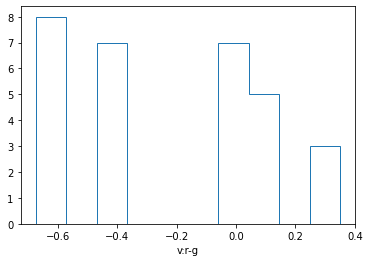

In [11]:
plt.hist(candSNe_w_color["v:r-g"], histtype='step')
plt.xlabel("v:r-g")

### Analysing the output: select alerts with color <-0.5

In [12]:
candSNe_w_color[candSNe_w_color["v:r-g"]<-0.5][['i:objectId',"v:r-g"]]

,i:objectId,v:r-g
22,ZTF21aaptouk,-0.673444
23,ZTF21aaptouk,-0.673444
25,ZTF21aannoix,-0.573558
27,ZTF21aannoix,-0.573558
30,ZTF21aaptouk,-0.673444
33,ZTF21aannoix,-0.573558
35,ZTF21aannoix,-0.573558
40,ZTF21aannoix,-0.573558


### Analysing the output: select alerts with color <0.5 and brighter than magpsf 19 (either filter) and less than 
this is the latest measured magnitude, not a projection

In [23]:
bright_candSNe_w_color = candSNe_w_color[(candSNe_w_color["v:r-g"]<-0.5) & (candSNe_w_color["i:magpsf"]<19)]
bright_candSNe_w_color[["i:objectId","i:magpsf","v:r-g"]]

,i:objectId,i:magpsf,v:r-g
23,ZTF21aaptouk,18.949867,-0.673444
25,ZTF21aannoix,17.797146,-0.573558
27,ZTF21aannoix,18.393297,-0.573558
33,ZTF21aannoix,17.650991,-0.573558
35,ZTF21aannoix,18.237000,-0.573558
40,ZTF21aannoix,17.573880,-0.573558


### API query: get photometry for one high-probability alert with color <0.5 and brighter than magpsf 19 (either filter)
Supernova scores are obtained using SuperNNova trained in two different ways: 

In [31]:
# very high probability
high_prob_objs = bright_candSNe_w_color[(bright_candSNe_w_color['d:snn_sn_vs_all']>0.8) | (bright_candSNe_w_color['d:snn_snia_vs_nonia']>0.8)]

In [36]:
high_prob_obj = high_prob_objs.sort_values(by=['i:ndethist'])['i:objectId'].iloc[0]

In [38]:
r = requests.post(
  'http://134.158.75.151:24000/api/v1/objects',
  json={
    'objectId': high_prob_obj,
    'output-format': 'json'
  }
)

# Format output in a DataFrame
single_object = pd.read_json(r.content)

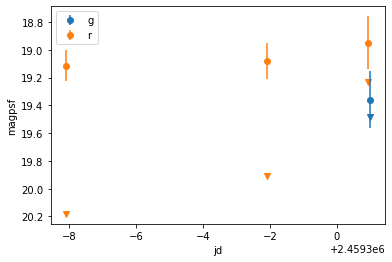

In [39]:
# import matplotlib.pyplot as plt
# dic_flt = {1:"g", 2:"r", 3:"i"}
# filter_color = {1: '#1f77b4', 2: '#ff7f0e', 3: '#2ca02c'}
for flt in [1,2]:
    df_byflt = single_object[single_object['i:fid']==flt]
    plt.errorbar(df_byflt['i:jd'], df_byflt['i:magpsf'], yerr=df_byflt['i:sigmapsf'],fmt='o',label=dic_flt[flt],color=filter_color[flt])
    plt.scatter(df_byflt['i:jd'],df_byflt['i:diffmaglim'],marker='v',color=filter_color[flt])
plt.xlabel('jd')
plt.ylabel('magpsf')
plt.gca().invert_yaxis()
plt.legend()

### API query: get thumbnails for one high-probability alert with color <0.5 and brighter than magpsf 19 (either filter)

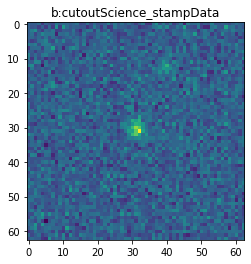

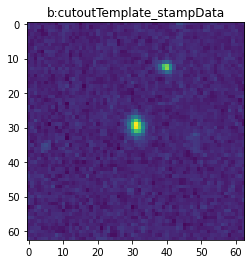

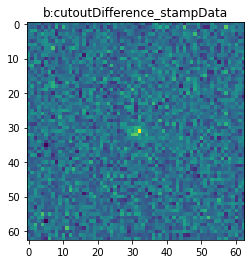

In [40]:
# import requests
# import pandas as pd
# import matplotlib.pyplot as plt

# transfer cutout data
r = requests.post(
  'http://134.158.75.151:24000/api/v1/objects',
  json={
    'objectId': high_prob_obj,
    'withcutouts': 'True'
  }
)

# Format output in a DataFrame
pdf = pd.read_json(r.content)

columns = [
    'b:cutoutScience_stampData',
    'b:cutoutTemplate_stampData',
    'b:cutoutDifference_stampData'
]

for col in columns:
    # 2D array
    data = pdf[col].values[0]

    # do whatever plotting
    plt.imshow(data)
    plt.title(col)
    plt.show()

# 3rd case study: type Ia supernovae in Fink
Type Ia supernovae recently classified and reported in TNS.

### API query: latest alerts associated with type Ia SNe

In [18]:
to do

SyntaxError: invalid syntax (<ipython-input-18-aef6d2462c89>, line 1)

### Analising the output: classification scores of these SNe

### Analising the output: SNe with close-by galaxies (not necessarily host-galaxies)